Steane code logical operation
========================

In this workbook logical operations for the Steane code are compared with the equivalent operations for a single qubit.

1. Set up logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474 

2. Set up a logical Hadamard, CX and X to produce a logical Bell pair.

3. Set up the ancilla

4. Set up the error correcting circuit

5. Set up the decoding circuit and measure the error.

Import the necessary function modules, including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

from circuits import SteaneCodeLogicalQubit

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from helper_functions import (
    count_valid_output_strings,
    find_individual_ancilla_values,
    find_ancilla_values,
    find_parity,
    get_noise,
    summarise_logical_counts,
    mean_of_list,
    calculate_standard_error,
    summarise_logical_counts,
    get_parity_check_matrix,
    get_codewords
    )

Define constants so the process flow can be controlled from one place:

In [2]:
DATA_QUBITS = 7
ANCILLA_QUBITS = 3
LOGICAL_QUBITS = 2

ERROR_REDUCTION = 1

MCT = True                                                #Use MCT gates
NOISE = False                                             #Test with noise
SHOTS = 10                                                #Number of shots to run    
MEASURE_NOISE = 0.0046 * ERROR_REDUCTION                  #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366 * ERROR_REDUCTION     #Single gate noise   
TWO_GATE_DEPOLARISING = 0.022 * ERROR_REDUCTION 
ITERATIONS = 1

SIMULATOR = Aer.get_backend('qasm_simulator')

Specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = get_parity_check_matrix()
print(parity_check_matrix)

['0001111', '0110011', '1010101']


The allowed codewords for the zero logical from Nielsen and Chuang is stored in a list.  Note, the order of qubits in the list is reversed compared to the normal output of Qiskit.

In [4]:
codewords = get_codewords()
print(codewords)

['0000000', '1010101', '0110011', '1100110', '0001111', '1011010', '0111100', '1101001']


In [5]:
#The allowed codewords for a single qubit Bell pair
valid_codewords = ['01','10']

In [6]:
def print_time():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    return

Single qubit circuit for Bell pair
---------------------------------------------

In [7]:
#set up scenarios
scenarios = {
            'No Transpilation' : 
                 {'Transpile': False},
            #'Transpilation': 
            #     {'Transpile': True}
            }

In [8]:
#set up scenarios ready to loop through
print(f'Run with {ITERATIONS} iteration and {SHOTS} shots')
error_rate_list = []
for cases, parameters in scenarios.items():
    print(f'For the scenario with {cases} ')
    transpilation = parameters.get('Transpile')
    for iteration in range(ITERATIONS):
        print(f'For iterations {iteration}')
        qr = QuantumRegister(2,'code_qubit')     # Two code QBits
        cr = ClassicalRegister(2,'syndrome_bit') # Two registers
        qc = QuantumCircuit(qr, cr)
        qc.reset(qr[0])
        qc.reset(qr[1])
        qc.h(qr[0])
        qc.x(qr[1])
        qc.cx(qr[0],qr[1])
        qc.measure(qr, cr)
        if transpilation:
            #use gate set for ion computer
            single_gate_set = ['id', 'ry', 'rx']
            two_gate_set = ['rxx']
            basis_gate_set = single_gate_set + two_gate_set
        else:
            #use standard gate set
            single_gate_set  = ['id', 'x', 'y', 'z', 'h']
            two_gate_set = ['cx', 'cz']
            basis_gate_set = single_gate_set + two_gate_set
        #initialise circuit
        if NOISE:
            noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, 
                                    TWO_GATE_DEPOLARISING, single_gate_set, two_gate_set
                                   )
        if transpilation:
            qt = transpile(qc, basis_gates =  basis_gate_set)
            if NOISE:
                result = execute(qt, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
            else:
                result = execute(qt, SIMULATOR, shots = SHOTS).result()
            counts = result.get_counts(qt)
        else:
            if NOISE:
                result = execute(qc, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
            else:
                result = execute(qc, SIMULATOR, shots = SHOTS).result()
            counts = result.get_counts(qc)

        count_valid, count_invalid, _ = count_valid_output_strings(counts, valid_codewords, 0)
        print(f'The results are {counts}')
        #print(f'Valid codewords {valid_codewords}')      
        error_rate = count_invalid / SHOTS
        print(f'The error rate is {error_rate:.4f}')
        print()
        error_rate_list.append(error_rate)
    mean_error = mean_of_list(error_rate_list)
    standard_deviation, standard_error = calculate_standard_error(error_rate_list)
    print(f'The mean error rate is {mean_error :.4f} and the standard error is {standard_error:.4f}')


Run with 1 iteration and 10 shots
For the scenario with No Transpilation 
For iterations 0
The results are {'01': 3, '10': 7}
The error rate is 0.0000

Unable to carry out standard error calcuation with one point. 
Standard error of 0 used.
The mean error rate is 0.0000 and the standard error is 0.0000


Circuit before transpilation

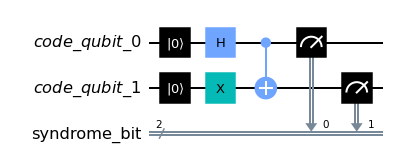

In [9]:
qc.draw(output = 'mpl', filename = './circuits/Single qubit Bell circuit.jpg', fold = 45)

Circuit after transpilation

In [10]:
#qt.draw(output = 'mpl', filename = './circuits/Transpiled single qubit Bell circuit.jpg', fold = 45)

Logical Bell pair
-----------------------

In [11]:
def set_up_circuit():
    qubit = SteaneCodeLogicalQubit(LOGICAL_QUBITS, parity_check_matrix, codewords)
    for index in range(LOGICAL_QUBITS):
        qubit.set_up_logical_zero(index)
    print('Logical_zero set up complete')
    print_time()
    qubit.barrier()
    qubit.logical_gate_H(0)
    qubit.logical_gate_X(1)    
    qubit.logical_gate_CX(0, 1)
    qubit.barrier()
    for index in range(LOGICAL_QUBITS):
        qubit.set_up_ancilla(index)
        qubit.barrier()
        qubit.correct_errors(index, MCT)
        qubit.barrier()
        qubit.decode(index)
        qubit.barrier()
        qubit.logical_measure_data(index)
        qubit.logical_measure_ancilla(index)
    return(qubit)

In [12]:
logical_zero = ['0000000']
logical_one = ['0010111']

In [13]:
#set up scenarios ready to loop through
scenarios = {
            'No Transpilation' : 
                 {'Transpile': False},
            #'Transpilation': 
            #     {'Transpile': True}
            }

In [14]:
print('Started running')
print_time()
for cases, parameters in scenarios.items():
    print(f'Running case {cases}')
    invalid_list = []
    for iteration in range(ITERATIONS):
        print(f'Running iteration {iteration}')
        print_time()
        qubit = set_up_circuit()
        transpilation = parameters.get('Transpile')
        if transpilation:
            #use gate set for ion computer
            single_gate_set = ['id', 'ry', 'rx']
            two_gate_set = ['rxx']
            basis_gate_set = single_gate_set + two_gate_set
            print('Transpilation complete')
        else:
            #use standard gate set
            single_gate_set  = ['id', 'x', 'y', 'z', 'h']
            two_gate_set = ['cx', 'cz']
            basis_gate_set = single_gate_set + two_gate_set
        if NOISE:
            noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, 
                                    TWO_GATE_DEPOLARISING, single_gate_set, two_gate_set)
            #print('Noise model set up')
            print_time()
        if transpilation:
            qt = transpile(qubit, basis_gates = basis_gate_set)
            if NOISE:
                result = execute(qt, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
            else:
                result = execute(qt, SIMULATOR, shots = SHOTS).result()
            counts = result.get_counts(qt)
        else:
            if NOISE:
                result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
            else:
                result = execute(qubit, SIMULATOR, shots = SHOTS).result()
            counts = result.get_counts(qubit)
        print(counts)
        #build summarised results
        new_counts = summarise_logical_counts(counts, logical_zero, logical_one, 2, 5)
        print(f'new counts {new_counts}')
        print_time()
        count_valid, count_invalid, _ = count_valid_output_strings(new_counts, valid_codewords, 0)
        print(f'For the scenario with {cases} ')
        print(f'The results are {counts}')
        print(f'Valid codewords {valid_codewords}')
        error_rate = count_invalid / SHOTS
        print(f'There are {count_invalid} invalid codewords')
        print(f'The cumulative error rate is {error_rate:.4f}')
        print_time()
        invalid_list.append(count_invalid)
    mean_invalid = mean_of_list(invalid_list)
    mean_error_rate = mean_invalid / SHOTS
    standard_deviation, standard_error = calculate_standard_error(invalid_list)
    print(f'On average there are {mean_invalid:.1f} invalid codewords with a standard error of {standard_error:.1f}')
    standard_error_on_error_rate = standard_error / SHOTS
    print(f'This is equivalent to an error rate of {mean_error_rate:.5f} with a standard error of {standard_error_on_error_rate} ')

Started running
Current Time = 14:14:52
Running case No Transpilation
Running iteration 0
Current Time = 14:14:52
Logical_zero set up complete
Current Time = 14:14:52
{'000 000 0000000 000 000 1110100': 2, '000 000 1110100 000 000 0000000': 8}
new counts {'00': 0, '01': 2, '02': 0, '10': 8, '11': 0, '12': 0, '20': 0, '21': 0, '22': 0}
Current Time = 14:20:52
For the scenario with No Transpilation 
The results are {'000 000 0000000 000 000 1110100': 2, '000 000 1110100 000 000 0000000': 8}
Valid codewords ['01', '10']
There are 0 invalid codewords
The cumulative error rate is 0.0000
Current Time = 14:20:52
Unable to carry out standard error calcuation with one point. 
Standard error of 0 used.
On average there are 0.0 invalid codewords with a standard error of 0.0
This is equivalent to an error rate of 0.00000 with a standard error of 0.0 


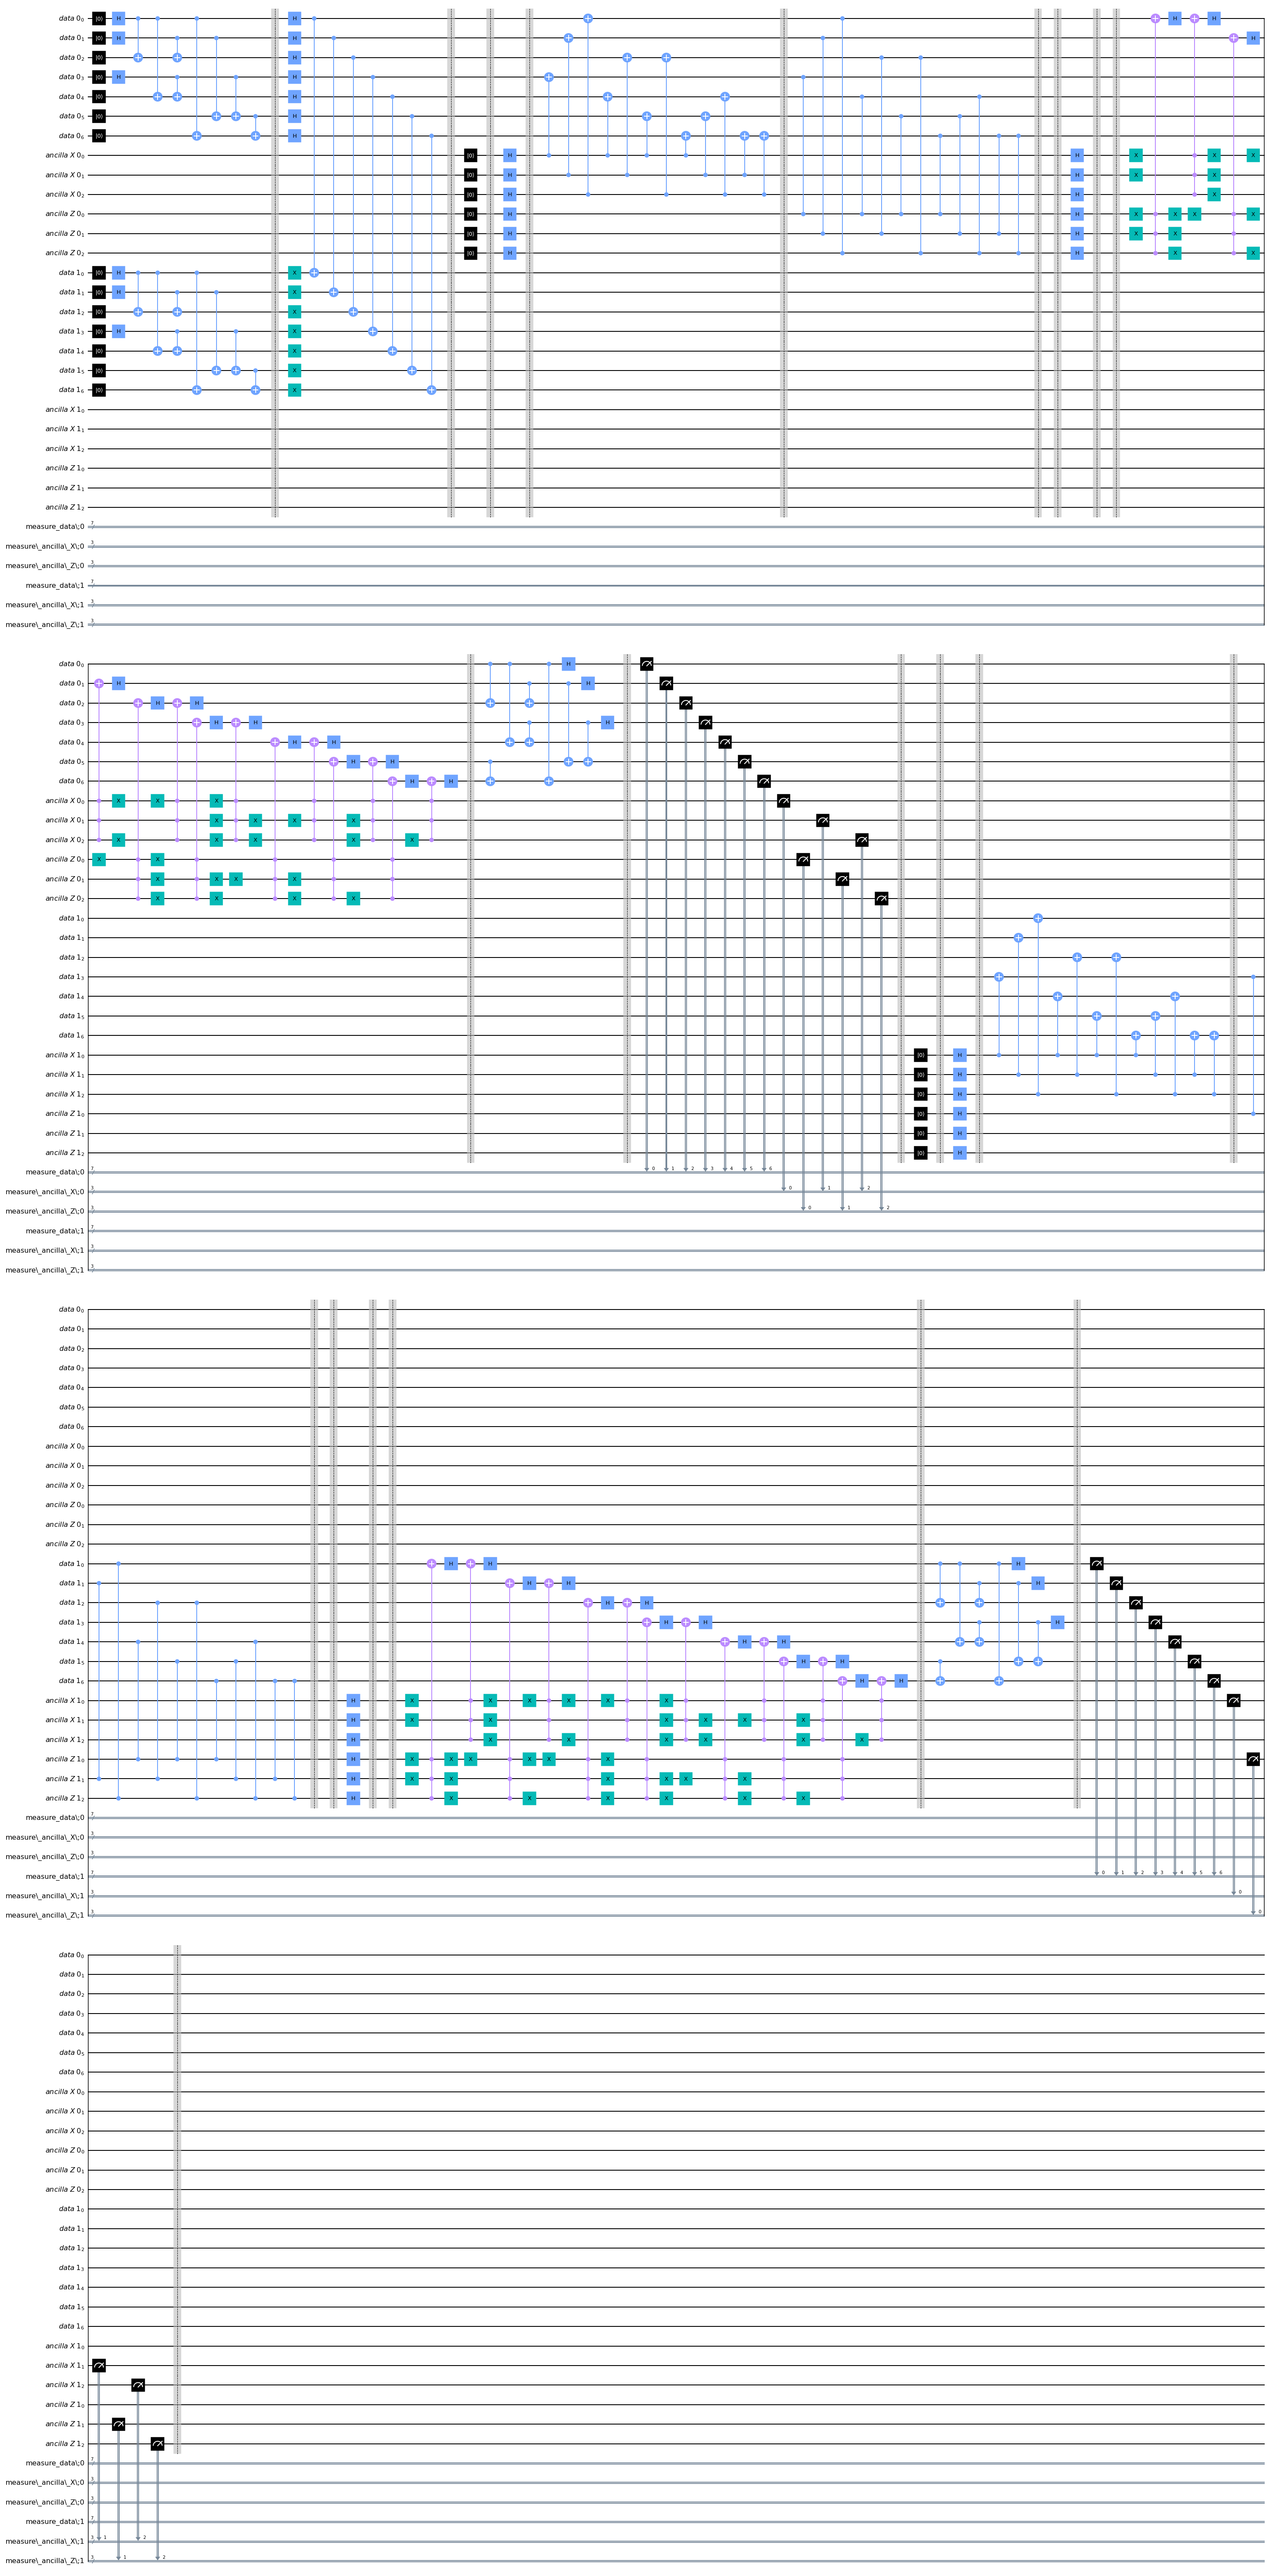

In [15]:
qubit.draw(output='mpl', filename = './circuits/Steane_code_logical_operations_circuit.jpg', fold=60)

In [16]:
#qt.draw(output='mpl', filename = './circuits/Steane_code_logical_operations_transpiled_circuit.jpg')